<a href="https://colab.research.google.com/github/shakuvish/TB_Detection/blob/main/TB_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os


print(f"📦 Original total images: {len(full_df)}")
full_df = full_df[full_df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"✅ Valid image paths: {len(full_df)}")

train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

train_dataset = ChestXrayDataset(train_df, transform)
val_dataset = ChestXrayDataset(val_df, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("✅ First batch loaded successfully!")
print("Batch shape:", images.shape, "| Labels:", labels)


📦 Original total images: 800
✅ Valid image paths: 800
✅ First batch loaded successfully!
Batch shape: torch.Size([16, 3, 224, 224]) | Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Device: cuda
✅ Data already in /content.
✅ Total valid images: 800


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ap to current tf_efficientnet_b0.ap_in1k.
  model = create_fn(
<ipython-input-2-66fbd4e32e8f>:111: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # ✅ Colab-compatible AMP



📚 Epoch 1/5


<ipython-input-2-66fbd4e32e8f>:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Train Loss: 0.6169, Acc: 65.78% | Val Loss: 0.4873, Acc: 74.38%

📚 Epoch 2/5
✅ Train Loss: 0.3807, Acc: 82.81% | Val Loss: 0.4281, Acc: 80.62%

📚 Epoch 3/5
✅ Train Loss: 0.2210, Acc: 93.59% | Val Loss: 0.4016, Acc: 84.38%

📚 Epoch 4/5
✅ Train Loss: 0.1339, Acc: 93.91% | Val Loss: 0.6185, Acc: 83.12%

📚 Epoch 5/5
✅ Train Loss: 0.0889, Acc: 97.03% | Val Loss: 0.5731, Acc: 85.00%

📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.81      0.84        78
Tuberculosis       0.83      0.89      0.86        82

    accuracy                           0.85       160
   macro avg       0.85      0.85      0.85       160
weighted avg       0.85      0.85      0.85       160



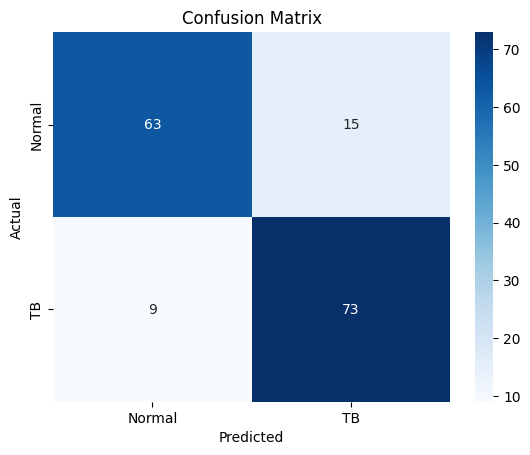

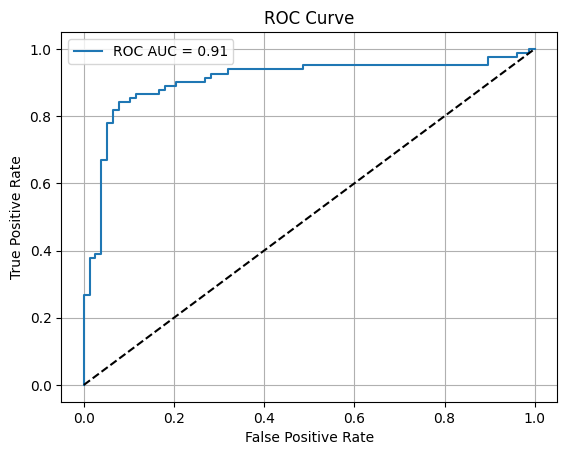

✅ Final ROC AUC: 0.9060


In [2]:
!pip install timm einops --quiet

from google.colab import drive
drive.mount('/content/drive')

import os, shutil
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import pandas as pd
import numpy as np
from PIL import Image
import timm
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

src_path = '/content/drive/MyDrive/TB_Dataset'
dst_path = '/content/data/TB_Dataset'

if not os.path.exists(dst_path):
    print("⏳ Copying data to /content...")
    shutil.copytree(src_path, dst_path)
    print("✅ Data copied.")
else:
    print("✅ Data already in /content.")

def load_dataset(dataset_folder):
    folder_path = os.path.join(dst_path, dataset_folder)
    metadata_file = [f for f in os.listdir(folder_path) if f.endswith('.csv')][0]
    metadata_path = os.path.join(folder_path, metadata_file)
    image_dir = os.path.join(folder_path, 'images', 'images')

    df = pd.read_csv(metadata_path)
    df['image_path'] = df['study_id'].apply(lambda x: os.path.join(image_dir, str(x).strip()))
    df['label'] = df['findings'].astype(str).str.lower().apply(lambda x: 0 if 'normal' in x else 1)
    return df[['image_path', 'label']]

mont_df = load_dataset('Tuberculosis Chest X-rays (Montgomery)')
shz_df = load_dataset('Tuberculosis Chest X-rays (Shenzhen)')
full_df = pd.concat([mont_df, shz_df], ignore_index=True)
full_df = full_df[full_df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"✅ Total valid images: {len(full_df)}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class TBXRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        try:
            image = Image.open(path).convert('RGB')
        except:
            return self.__getitem__((idx + 1) % len(self.df))
        if self.transform:
            image = self.transform(image)
        return image, label

train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)
train_dataset = TBXRayDataset(train_df, transform)
val_dataset = TBXRayDataset(val_df, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

class EfficientNetViTFusion(nn.Module):
    def __init__(self, eff='tf_efficientnet_b0_ap', vit='vit_base_patch16_224', num_classes=2):
        super().__init__()
        self.eff = timm.create_model(eff, pretrained=True, num_classes=0, global_pool='')
        self.vit = timm.create_model(vit, pretrained=True, num_classes=0)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Linear(self.eff.num_features + self.vit.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        eff_feat = self.pool(self.eff(x)).squeeze(-1).squeeze(-1)
        vit_feat = self.vit(x)
        x = torch.cat((eff_feat, vit_feat), dim=1)
        return self.fc(x)

model = EfficientNetViTFusion().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()

def train_amp(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


for epoch in range(1, 6):
    print(f"\n📚 Epoch {epoch}/5")
    train_loss, train_acc = train_amp(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    print(f"✅ Train Loss: {train_loss:.4f}, Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2%}")

model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_true.extend(labels)
        y_pred.extend(probs.argmax(dim=1).cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Final ROC AUC: {roc_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


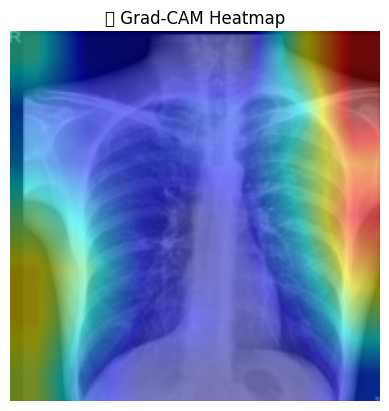

In [7]:
!pip install grad-cam --quiet

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import resize

target_layers = [model.eff.conv_head]

sample_path = val_df.sample(1)['image_path'].values[0]
img = Image.open(sample_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

img_np = np.array(resize(img, (224, 224))) / 255.0
img_np = np.float32(img_np)

cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=img_tensor)[0]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title("🔥 Grad-CAM Heatmap")
plt.axis('off')
plt.show()


📷 Prediction: Tuberculosis (99.74% TB)


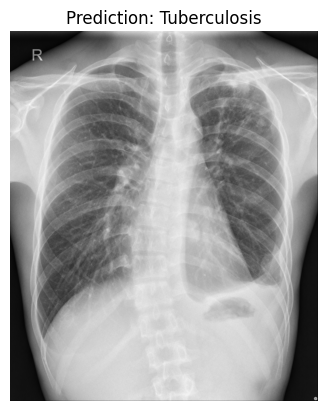

In [4]:
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.softmax(output, dim=1).cpu().numpy()
    label = "Tuberculosis" if pred[0][1] > 0.5 else "Normal"
    print(f"📷 Prediction: {label} ({pred[0][1]*100:.2f}% TB)")
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

predict_image(val_df.sample(1).iloc[0]['image_path'])


<ipython-input-14-57a61881f4bc>:87: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-57a61881f4bc>:87: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-57a61881f4bc>:87: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129659 (\N{X-RAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


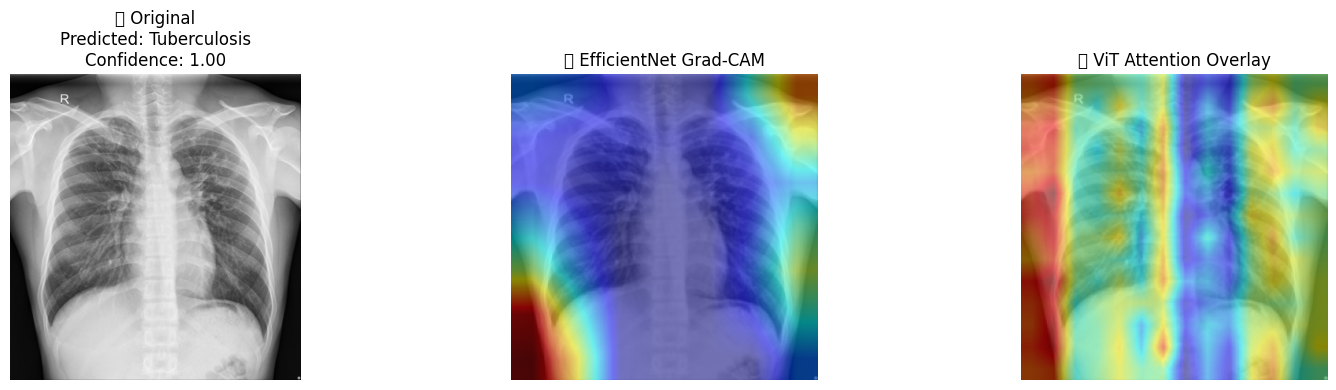

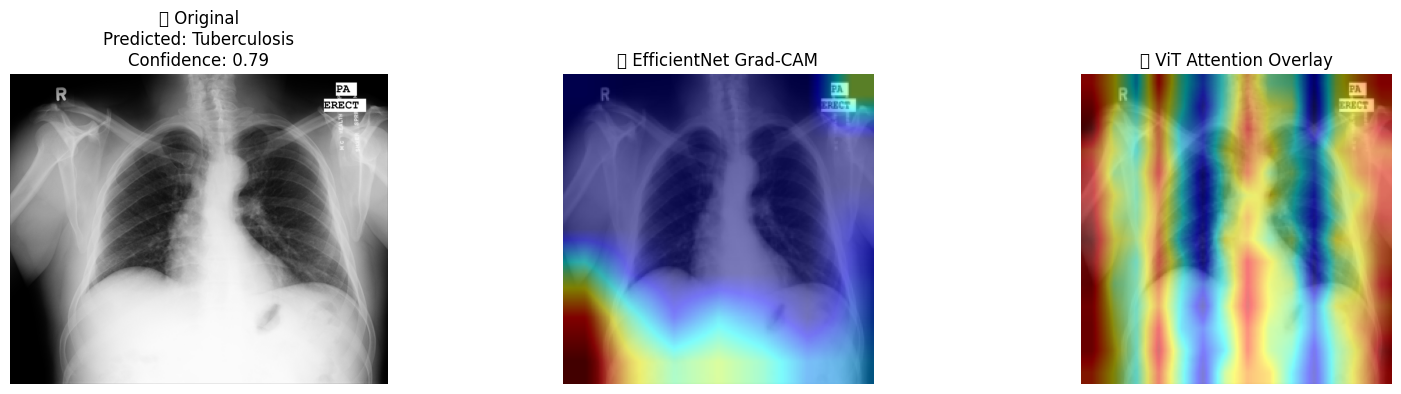

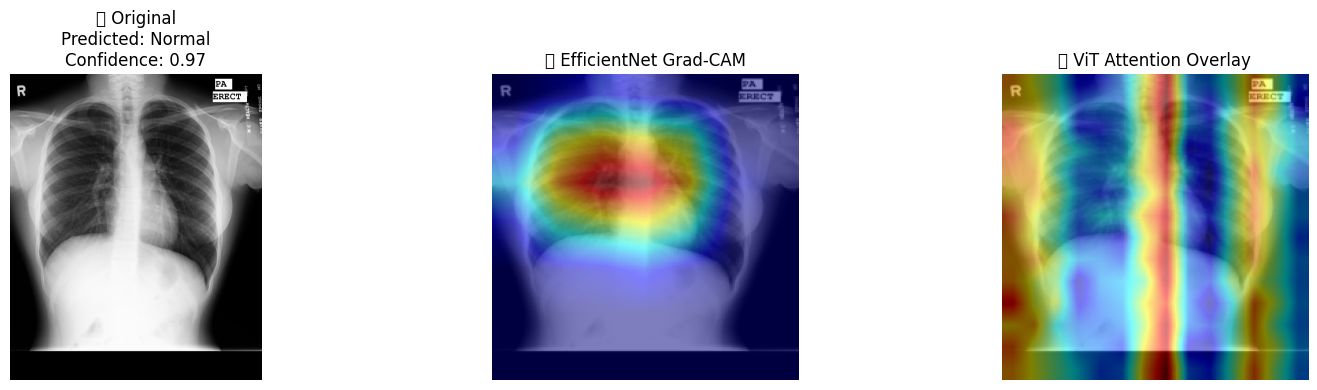

In [14]:
import random
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

def get_vit_cls_attention(vit_model, input_tensor):
    with torch.no_grad():
        x = vit_model.patch_embed(input_tensor)
        B = x.shape[0]
        cls_token = vit_model.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = vit_model.pos_drop(x + vit_model.pos_embed)

        attn = None
        for blk in vit_model.blocks:
            x, attn_probs = blk.forward_with_attn(x)
            attn = attn_probs

        cls_attn = attn[:, 0, 1:]
        npatches = cls_attn.shape[-1]
        h = w = int(np.sqrt(npatches))

        if h * w == npatches:
            attn_map = cls_attn.reshape(B, 1, h, w).cpu()
        else:
            attn_map = cls_attn.unsqueeze(1)
            attn_map = F.interpolate(attn_map, size=(14, 14), mode="bilinear", align_corners=False).cpu()

        return attn_map.squeeze().numpy()

def overlay_attention_on_image(image_np, attention_map):
    attention_resized = cv2.resize(attention_map, (224, 224))
    attention_normalized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())
    attention_colored = cv2.applyColorMap(np.uint8(255 * attention_normalized), cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(np.uint8(image_np * 255), 0.5, attention_colored, 0.5, 0)
    return overlayed

def predict_and_explain(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    img_np = np.array(resize(img, (224, 224))) / 255.0
    img_np = np.float32(img_np)

    with torch.no_grad():
        output = model(img_tensor)
        pred_prob = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_label = np.argmax(pred_prob)
        confidence = pred_prob[pred_label]
        label_str = "Tuberculosis" if pred_label == 1 else "Normal"


    eff_cam = GradCAM(model=model, target_layers=[model.eff.conv_head])
    eff_grayscale = eff_cam(input_tensor=img_tensor)[0]
    eff_vis = show_cam_on_image(img_np, eff_grayscale, use_rgb=True)

    attn_map = get_vit_cls_attention(model.vit, img_tensor)
    attn_overlay = overlay_attention_on_image(img_np, attn_map)


    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"🩻 Original\nPredicted: {label_str}\nConfidence: {confidence:.2f}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(eff_vis)
    plt.title("🔥 EfficientNet Grad-CAM")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(attn_overlay)
    plt.title("🧠 ViT Attention Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for sample in random.sample(val_df.to_dict("records"), 3):
    predict_and_explain(sample["image_path"])
